# Regression with Orbit

In this notebook, we want to demonstartate how to use the different arguments in the model classes (LGT or DLT) to realize different setups for the regressors. Those could be very useful in practice when tuning the models. Here includes two example, one with 

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.models.dlt import DLTMAP, DLTAggregated, DLTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims

plt.style.use('fivethirtyeight')

# SFO Air Passenger Data

In [41]:
# load dataset
sfo_passenger = pd.read_csv('./data/air-traffic-passenger-statistics.csv.zip')

# convert the activity period into date
sfo_passenger['date'] = [datetime.datetime.strptime(str(i) + '01', '%Y%m%d').date() for i in sfo_passenger['Activity Period']]

In [42]:
sfo_passenger.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,date
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271,2005-07-01
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131,2005-07-01
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415,2005-07-01
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156,2005-07-01
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090,2005-07-01


In [48]:
df = pd.DataFrame(sfo_passenger.groupby('date')['Passenger Count'].sum()).reset_index()
df['date'] = pd.to_datetime(df['date'])

In [49]:
df.head()

,date,Passenger Count
0,2005-07-01,3225769
1,2005-08-01,3195866
2,2005-09-01,2740553
3,2005-10-01,2770715
4,2005-11-01,2617333


In [63]:
sfo_passenger.tail()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,date
18880,201806,WOW Air,WW,WOW Air,WW,International,Europe,Enplaned,Other,International,G,50,2018-06-01
18881,201806,WestJet Airlines,WS,WestJet Airlines,WS,International,Canada,Deplaned,Other,International,A,10868,2018-06-01
18882,201806,WestJet Airlines,WS,WestJet Airlines,WS,International,Canada,Enplaned,Other,International,A,11664,2018-06-01
18883,201806,XL Airways France,SE,XL Airways France,SE,International,Europe,Deplaned,Other,International,A,804,2018-06-01
18884,201806,XL Airways France,SE,XL Airways France,SE,International,Europe,Enplaned,Other,International,A,1243,2018-06-01


In [50]:
df.dtypes

date               datetime64[ns]
Passenger Count             int64
dtype: object

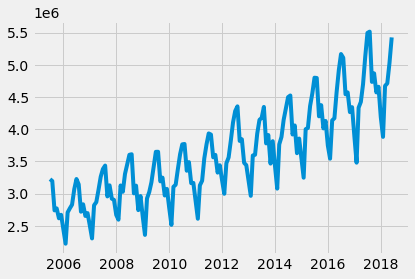

In [62]:
plt.plot(df['date'], df['Passenger Count'])

# With Simulation Data